# Seq2Vec Sentiment Analysis Modeling in Tensorflow

## 1.0 - Import Packages

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
import tensorflow_hub as hub
import pandas as pd
from keras.layers import Dropout
import os
import numpy as np
import nltk
import xgboost
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
CUR_DIR = os.path.abspath(os.curdir)
ROOT_DIR = os.path.dirname(CUR_DIR)
IMAGES_DIR = os.path.join(ROOT_DIR, "images")
DATA_DIR = os.path.join(ROOT_DIR, "data")
MODELS_DIR = os.path.join(ROOT_DIR, "models")
MODELS_DIR

'/home/jovyan/projects/vector-nlp/models'

## 1.1 Import Data 

In [7]:
validation_df = pd.read_csv(os.path.join(DATA_DIR,'raw','validation.csv'))
training_df = pd.read_csv(os.path.join(DATA_DIR,'raw','training.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR,'raw','test.csv'))


In [8]:
X_train = training_df['review']
y_train = training_df['star']

X_val = validation_df['review']
y_val = validation_df['star']

X_test = test_df['review']
y_test = test_df['star']

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val))

## 2.0 Create embedding layer & Build simple model

In [30]:
handle = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1'
emb_layer = hub.KerasLayer(handle = handle,
               input_shape=[],dtype=tf.string,trainable=True)

In [29]:
embed = hub.load(handle)
embeddings = embed(["hello","hello"])
embeddings

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[ 0.52211034, -0.5292976 ,  0.33719632,  0.0902942 , -0.6266122 ,
         0.45860922, -0.70826894,  0.55458295,  1.1077714 ,  0.40197402,
        -1.5735748 ,  0.35205668,  0.8920213 , -0.05832118, -0.29793447,
        -0.2865127 ,  0.7564523 ,  0.6519507 , -0.7274325 , -0.45961407],
       [ 0.52211034, -0.5292976 ,  0.33719632,  0.0902942 , -0.6266122 ,
         0.45860922, -0.70826894,  0.55458295,  1.1077714 ,  0.40197402,
        -1.5735748 ,  0.35205668,  0.8920213 , -0.05832118, -0.29793447,
        -0.2865127 ,  0.7564523 ,  0.6519507 , -0.7274325 , -0.45961407]],
      dtype=float32)>

In [88]:
epochs = 200
emb_layer = hub.KerasLayer(handle = handle, output_shape=(20,),
               input_shape=(),dtype=tf.string,trainable=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

base_model = keras.Sequential([
        emb_layer,
        layers.Dense(10,activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1,activation='relu')])
base_model.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=keras.optimizers.Adam(lr=0.00005,decay=1e-6),metrics=['mse','mae'])


base_history = base_model.fit(train_ds.batch(128),#.shuffle(2000).batch(128),
                    epochs = epochs,
                    validation_data=val_ds.batch(128),#.batch(128),
                    callbacks=[callback],
                    verbose=1)

Epoch 1/200
1351/1351 [==============================] - 9s 6ms/step - loss: 10.5404 - mse: 10.5404 - mae: 2.8891 - val_loss: 6.1315 - val_mse: 6.1315 - val_mae: 2.1505
Epoch 2/200
1351/1351 [==============================] - 8s 6ms/step - loss: 5.1107 - mse: 5.1107 - mae: 1.8981 - val_loss: 4.0109 - val_mse: 4.0109 - val_mae: 1.6488
Epoch 3/200
1351/1351 [==============================] - 8s 6ms/step - loss: 3.9929 - mse: 3.9929 - mae: 1.6268 - val_loss: 3.3376 - val_mse: 3.3376 - val_mae: 1.4830
Epoch 4/200
1351/1351 [==============================] - 8s 6ms/step - loss: 3.4796 - mse: 3.4796 - mae: 1.5093 - val_loss: 2.8754 - val_mse: 2.8754 - val_mae: 1.3751
Epoch 5/200
1351/1351 [==============================] - 8s 6ms/step - loss: 3.0644 - mse: 3.0644 - mae: 1.4105 - val_loss: 2.5243 - val_mse: 2.5243 - val_mae: 1.2885
Epoch 6/200
1351/1351 [==============================] - 8s 6ms/step - loss: 2.7594 - mse: 2.7594 - mae: 1.3358 - val_loss: 2.2656 - val_mse: 2.2656 - val_mae: 1.2

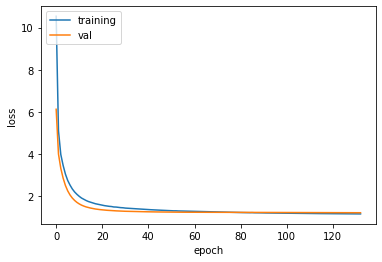

In [89]:
import matplotlib.pyplot as plt
plt.plot(base_history.history['loss'], label='training')
plt.plot(base_history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

In [90]:
y_pred = base_model.predict(X_test)
y_pred

array([[4.670684 ],
       [2.7985737],
       [2.724489 ],
       ...,
       [2.8548956],
       [3.7767649],
       [4.2959566]], dtype=float32)

In [91]:
max(y_pred)

array([6.3934717], dtype=float32)

In [92]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.8172741827726335

In [93]:
base_model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_21 (KerasLayer)  (None, 20)                389380    
_________________________________________________________________
dense_62 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 11        
Total params: 389,601
Trainable params: 389,601
Non-trainable params: 0
_________________________________________________________________


In [18]:
base_model.save(os.path.join(MODELS_DIR,'baseline-dl-model'))

2022-03-07 03:35:23.959751: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-LSTM_TFIDF/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-LSTM_TFIDF/assets


In [19]:
new_model = tf.keras.models.load_model(os.path.join(MODELS_DIR,'2.1-LSTM_TFIDF'))
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          4385152   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,459,521
Trainable params: 4,459,521
Non-trainable params: 0
_________________________________________________________________


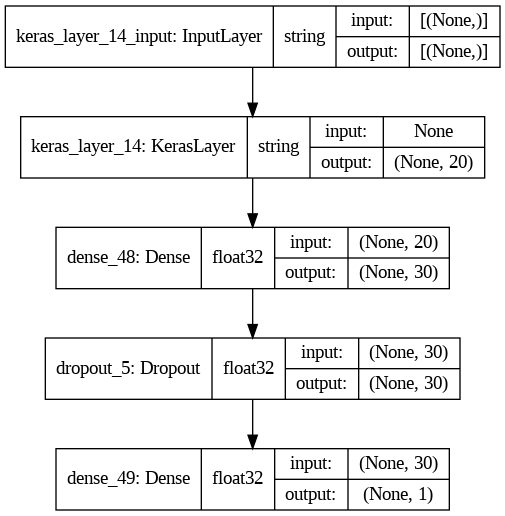

In [94]:
path = os.path.join(IMAGES_DIR,'2.1-LSTM_MODEL_PLOT.png')
tf.keras.utils.plot_model(model,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [95]:
eval_df = pd.merge(X_test, y_test, left_index=True, right_index=True)
eval_df['prediction'] = base_model.predict(eval_df.review).ravel()
eval_df['absolute_error'] = (eval_df['prediction'] - eval_df['star']).abs()
eval_df

,review,star,prediction,absolute_error
0,Very fast,5,4.670684,0.329316
1,Good app It still has pops and pauses,4,2.798574,1.201426
2,Google play services Have not tried it yet.,4,2.724489,1.275511
3,It's a average working,1,3.233011,2.233011
4,annoying notification that made my phone to cr...,1,1.612642,0.612642
...,...,...,...,...
57608,Deep web If u are trying to go on the deep Web...,5,2.996448,2.003552
57609,nice It is a key app to your device though It ...,4,3.262773,0.737227
57610,To many fuking glitchs,2,2.854896,0.854896
57611,Theives If you turn on quick torch settings th...,1,3.776765,2.776765


## RNN

In [108]:
embed
embed(X_train).shape

TensorShape([172839, 20])

In [152]:
rnn_emb_layer = emb_layer = hub.KerasLayer(handle = handle, output_shape=[20],
               input_shape=(),dtype=tf.string,trainable=True)
rnn_model = tf.keras.Sequential([
    rnn_emb_layer,
    layers.Reshape(target_shape= (20,1)),
    # layers.Dense(20,activation='relu'),
    # layers.SimpleRNN(20,return_sequences=True,input_shape=(None, 20), activation='relu'),
    layers.SimpleRNN(15,input_shape=(None, 20), activation='tanh',return_sequences=True),
    layers.SimpleRNN(10,input_shape=(None, 15), activation='tanh',return_sequences=False),
    layers.Dense(5,activation='tanh'),
    layers.Dense(1,activation='relu')
])
rnn_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
rnn_history=rnn_model.fit(X_train, 
                          y_train, 
                          epochs=num_epochs, 
                          validation_data = (X_val, y_val), 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
5402/5402 [==============================] - 85s 16ms/step - loss: 1.7686 - mse: 1.7686 - mae: 1.0210 - val_loss: 1.2425 - val_mse: 1.2425 - val_mae: 0.8233
Epoch 2/100
5402/5402 [==============================] - 86s 16ms/step - loss: 1.1989 - mse: 1.1989 - mae: 0.8035 - val_loss: 1.2771 - val_mse: 1.2771 - val_mae: 0.7720
Epoch 3/100
5402/5402 [==============================] - 86s 16ms/step - loss: 1.1469 - mse: 1.1469 - mae: 0.7780 - val_loss: 1.1950 - val_mse: 1.1950 - val_mae: 0.7998
Epoch 4/100
5402/5402 [==============================] - 87s 16ms/step - loss: 1.1098 - mse: 1.1098 - mae: 0.7585 - val_loss: 1.1947 - val_mse: 1.1947 - val_mae: 0.7739
Epoch 5/100
5402/5402 [==============================] - 89s 16ms/step - loss: 1.0768 - mse: 1.0768 - mae: 0.7410 - val_loss: 1.2278 - val_mse: 1.2278 - val_mae: 0.7702
Epoch 6/100
5402/5402 [==============================] - 88s 16ms/step - loss: 1.0484 - mse: 1.0484 - mae: 0.7264 - val_loss: 1.2167 - val_mse: 1.2167 - va

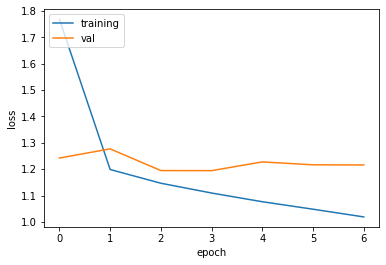

In [153]:
plt.plot(rnn_history.history['loss'], label='training')
plt.plot(rnn_history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

In [154]:
y_pred = rnn_model.predict(X_test)
y_pred

array([[4.7266855],
       [3.9887102],
       [3.47953  ],
       ...,
       [1.4645511],
       [3.9329932],
       [4.7164497]], dtype=float32)

In [149]:
y_pred[0]

array([4.746273], dtype=float32)

In [155]:
rnn_eval_df = pd.merge(X_test, y_test, left_index=True, right_index=True)
rnn_eval_df['prediction'] = rnn_model.predict(rnn_eval_df.review).ravel()
rnn_eval_df['absolute_error'] = (rnn_eval_df['prediction'] - rnn_eval_df['star']).abs()
rnn_eval_df

,review,star,prediction,absolute_error
0,Very fast,5,4.726686,0.273314
1,Good app It still has pops and pauses,4,3.988710,0.011290
2,Google play services Have not tried it yet.,4,3.479530,0.520470
3,It's a average working,1,1.903485,0.903485
4,annoying notification that made my phone to cr...,1,1.415272,0.415272
...,...,...,...,...
57608,Deep web If u are trying to go on the deep Web...,5,2.288877,2.711123
57609,nice It is a key app to your device though It ...,4,3.649062,0.350938
57610,To many fuking glitchs,2,1.464551,0.535449
57611,Theives If you turn on quick torch settings th...,1,3.932993,2.932993


In [156]:
gru_emb_layer = emb_layer = hub.KerasLayer(handle = handle, output_shape=[20],
               input_shape=(),dtype=tf.string,trainable=True)
gru_model = tf.keras.Sequential([
    gru_emb_layer,
    layers.Reshape(target_shape= (20,1)),
    # layers.Dense(20,activation='relu'),
    # layers.SimpleRNN(20,return_sequences=True,input_shape=(None, 20), activation='relu'),
    layers.GRU(15,input_shape=(None, 20), activation='tanh',return_sequences=True),
    layers.GRU(10,input_shape=(None, 15), activation='tanh',return_sequences=False),
    layers.Dense(5,activation='tanh'),
    layers.Dense(1,activation='relu')
])
gru_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
gru_history=gru_model.fit(X_train, 
                          y_train, 
                          epochs=num_epochs, 
                          validation_data = (X_val, y_val), 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
5402/5402 [==============================] - 139s 25ms/step - loss: 1.6557 - mse: 1.6557 - mae: 0.9810 - val_loss: 1.2574 - val_mse: 1.2574 - val_mae: 0.8061
Epoch 2/100
5402/5402 [==============================] - 136s 25ms/step - loss: 1.1981 - mse: 1.1981 - mae: 0.7979 - val_loss: 1.2115 - val_mse: 1.2115 - val_mae: 0.7810
Epoch 3/100
5402/5402 [==============================] - 137s 25ms/step - loss: 1.1466 - mse: 1.1466 - mae: 0.7712 - val_loss: 1.1946 - val_mse: 1.1946 - val_mae: 0.7504
Epoch 4/100
5402/5402 [==============================] - 138s 25ms/step - loss: 1.1156 - mse: 1.1156 - mae: 0.7533 - val_loss: 1.2015 - val_mse: 1.2015 - val_mae: 0.7658
Epoch 5/100
5402/5402 [==============================] - 137s 25ms/step - loss: 1.0923 - mse: 1.0923 - mae: 0.7401 - val_loss: 1.1807 - val_mse: 1.1807 - val_mae: 0.7860
Epoch 6/100
5402/5402 [==============================] - 135s 25ms/step - loss: 1.0738 - mse: 1.0738 - mae: 0.7304 - val_loss: 1.1935 - val_mse: 1.193

In [157]:
y_pred = gru_model.predict(X_test)
y_pred

array([[4.6496973],
       [4.208935 ],
       [2.2171977],
       ...,
       [1.8885076],
       [4.565089 ],
       [4.7328033]], dtype=float32)

In [158]:
gru_eval_df = pd.merge(X_test, y_test, left_index=True, right_index=True)
gru_eval_df['prediction'] = gru_model.predict(gru_eval_df.review).ravel()
gru_eval_df['absolute_error'] = (gru_eval_df['prediction'] - gru_eval_df['star']).abs()
gru_eval_df

,review,star,prediction,absolute_error
0,Very fast,5,4.649697,0.350303
1,Good app It still has pops and pauses,4,4.208935,0.208935
2,Google play services Have not tried it yet.,4,2.217198,1.782802
3,It's a average working,1,2.975333,1.975333
4,annoying notification that made my phone to cr...,1,2.037428,1.037428
...,...,...,...,...
57608,Deep web If u are trying to go on the deep Web...,5,3.205246,1.794754
57609,nice It is a key app to your device though It ...,4,3.495338,0.504662
57610,To many fuking glitchs,2,1.888508,0.111492
57611,Theives If you turn on quick torch settings th...,1,4.565089,3.565089


In [160]:
max(y_pred)

array([4.9485197], dtype=float32)

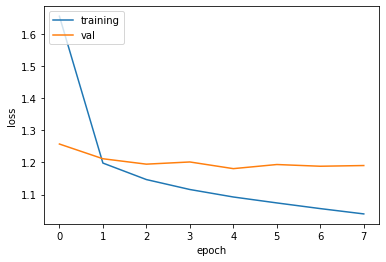

In [161]:
plt.plot(gru_history.history['loss'], label='training')
plt.plot(gru_history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()